# Data driven approach

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Import data
experiments = pd.read_csv("/workspaces/MA932-Project/n73_stabilization.csv")
# NOTE: Fixed radius 16.75
experiments = experiments[['TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']] # Columns of interest

In [2]:
print(min(experiments['POSITION_X']) - 16.75)
print(max(experiments['POSITION_X']) + 16.75)

3.556000000000001
478.879


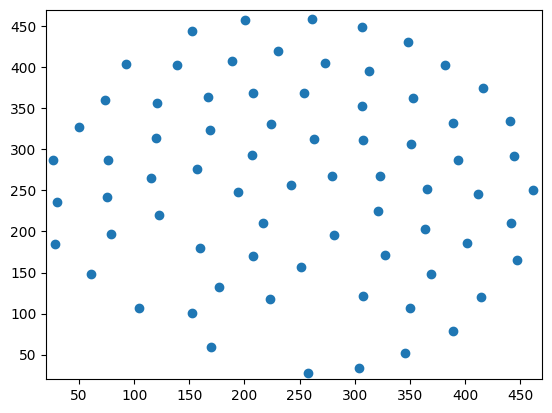

In [3]:
# Create trajectories animation

frames_num = len(pd.unique(experiments['FRAME']))

# Create a figure and axis
fig, ax = plt.subplots()

# Create an empty scatter plot (initially no balls are shown)
scatter = ax.scatter([], [])
ax.set(xlim=[20, 470], ylim=[20, 470])

# Function to update the scatter plot with new ball positions
def update(frame):
    frame_df = experiments[experiments['FRAME'] == frame]
    x = frame_df['POSITION_X']
    y = frame_df['POSITION_Y']

    # update the scatter plot:
    data = np.stack([x, y]).T
    scatter.set_offsets(data)

    return scatter,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(frames_num), interval=50, blit=True)
#ani.save('animation.gif', writer='pillow')
plt.show()

/tmp/ipykernel_1295/2003079048.py:41: RuntimeWarning: invalid value encountered in scalar divide
  vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)


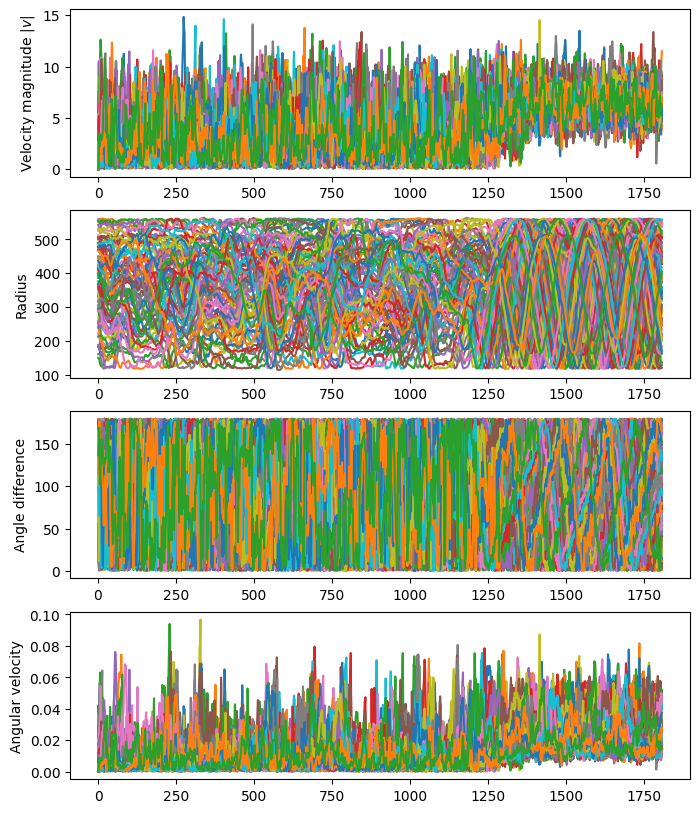

In [4]:
import matplotlib.pyplot as plt

#fig, (ax_v, ax_r, ax_ang, ax_angv) = plt.subplots(4, 1, figsize=(8, 10))
fig, (ax_v, ax_r, ax_ang, ax_angv) = plt.subplots(4, 1, figsize=(8, 10))
 
for a in pd.unique(experiments['TRACK_ID']):
    if not (a == 73):
        # Calculate v, w and r per agent
        agent = experiments[experiments['TRACK_ID'] == a]

        vel_x = np.zeros(len(agent['FRAME']))
        vel_y = np.zeros(len(agent['FRAME']))
        vel_mag = np.zeros(len(agent['FRAME']))

        ang = np.zeros(len(agent['FRAME']))
        ang_vel = np.zeros(len(agent['FRAME']))

        r = np.zeros(len(agent['FRAME']))

        ind_prev = agent[agent['FRAME'] == 0].index
        x_prev = agent.loc[ind_prev, 'POSITION_X'].iloc[0]
        y_prev = agent.loc[ind_prev, 'POSITION_Y'].iloc[0]

        r[0] =  np.sqrt(x_prev**2 + y_prev**2)
        r_prev = r[0]

        # Assume unit time step per frame
        frames = agent.sort_values(by='FRAME')['FRAME'].values
        for i in frames:
            ind = agent[agent['FRAME'] == i].index
            x = agent.loc[ind, 'POSITION_X'].iloc[0]
            y = agent.loc[ind, 'POSITION_Y'].iloc[0]

            vel_x[i] = x - x_prev
            vel_y[i] = y - y_prev
            vel_mag[i] = np.sqrt(vel_x[i]**2 + vel_y[i]**2)

            r[i] =  np.sqrt(x**2 + y**2)
            ang_vel[i] = vel_mag[i]/r[i]

            vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)
            angle_rad = np.arccos(vec_cos)
            ang[i] = np.degrees(angle_rad)

            # Update values
            ind_prev = ind
            x_prev = x
            y_prev = y
            r_prev = r[i]

        vwr_df = pd.DataFrame({'TRACK_ID': agent['TRACK_ID'], 'FRAME': frames,
                            'VELOCITY_X': vel_x, 'VELOCITY_Y': vel_y, 'VELOCITY_MAG': vel_mag, 
                            'RADIUS': r, 'ANGULAR_VELOCITY': ang_vel})
        
        ax_v.plot(frames, vel_mag)
        ax_r.plot(frames, r)
        ax_ang.plot(frames, ang)
        ax_angv.plot(frames, ang_vel)

ax_v.set_ylabel('Velocity magnitude $\\vert v \\vert$')
ax_r.set_ylabel('Radius')
ax_ang.set_ylabel('Angle difference')
ax_angv.set_ylabel('Angular velocity')
plt.show()

/tmp/ipykernel_1295/2488731110.py:41: RuntimeWarning: invalid value encountered in scalar divide
  vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)


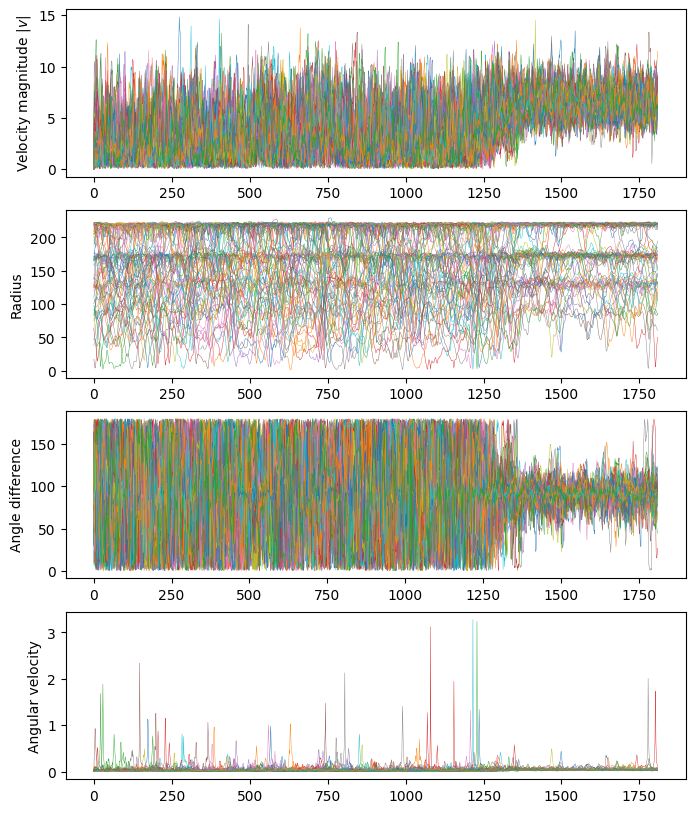

In [5]:
import matplotlib.pyplot as plt

#fig, (ax_v, ax_r, ax_ang, ax_angv) = plt.subplots(4, 1, figsize=(8, 10))
fig, (ax_v, ax_r, ax_ang, ax_angv) = plt.subplots(4, 1, figsize=(8, 10))
 
for a in pd.unique(experiments['TRACK_ID']):
    if not (a == 73):
        # Calculate v, w and r per agent
        agent = experiments[experiments['TRACK_ID'] == a]

        vel_x = np.zeros(len(agent['FRAME']))
        vel_y = np.zeros(len(agent['FRAME']))
        vel_mag = np.zeros(len(agent['FRAME']))

        ang = np.zeros(len(agent['FRAME']))
        ang_vel = np.zeros(len(agent['FRAME']))

        r = np.zeros(len(agent['FRAME']))

        ind_prev = agent[agent['FRAME'] == 0].index
        x_prev = agent.loc[ind_prev, 'POSITION_X'].iloc[0] - 240
        y_prev = agent.loc[ind_prev, 'POSITION_Y'].iloc[0] - 240

        r[0] =  np.sqrt(x_prev**2 + y_prev**2)
        r_prev = r[0]

        # Assume unit time step per frame
        frames = agent.sort_values(by='FRAME')['FRAME'].values
        for i in frames:
            ind = agent[agent['FRAME'] == i].index
            x = agent.loc[ind, 'POSITION_X'].iloc[0] - 240
            y = agent.loc[ind, 'POSITION_Y'].iloc[0] - 240

            vel_x[i] = x - x_prev
            vel_y[i] = y - y_prev
            vel_mag[i] = np.sqrt(vel_x[i]**2 + vel_y[i]**2)

            r[i] =  np.sqrt(x**2 + y**2)
            ang_vel[i] = vel_mag[i]/r[i]

            vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)
            angle_rad = np.arccos(vec_cos)
            ang[i] = np.degrees(angle_rad)

            # Update values
            ind_prev = ind
            x_prev = x
            y_prev = y
            r_prev = r[i]

        vwr_df = pd.DataFrame({'TRACK_ID': agent['TRACK_ID'], 'FRAME': frames,
                            'VELOCITY_X': vel_x, 'VELOCITY_Y': vel_y, 'VELOCITY_MAG': vel_mag, 
                            'RADIUS': r, 'ANGULAR_VELOCITY': ang_vel, 'ANGLE_DIFF': ang})
        
        ax_v.plot(frames, vel_mag, linewidth=0.3)
        ax_r.plot(frames, r, linewidth=0.3)
        ax_ang.plot(frames, ang, linewidth=0.3)
        ax_angv.plot(frames, ang_vel, linewidth=0.3)

ax_v.set_ylabel('Velocity magnitude $\\vert v \\vert$')
ax_r.set_ylabel('Radius')
ax_ang.set_ylabel('Angle difference')
ax_angv.set_ylabel('Angular velocity')
plt.show()

In [31]:
# Data frame
import matplotlib.pyplot as plt

vwr_df = pd.DataFrame(columns=['TRACK_ID', 'FRAME', 'VELOCITY_X', 'VELOCITY_Y', 'VELOCITY_MAG', 
                               'RADIUS', 'ANGULAR_VELOCITY', 'ANGLE_DIFF'])
 
for a in pd.unique(experiments['TRACK_ID']):
    if not (a == 73):
        # Calculate v, w and r per agent
        agent = experiments[experiments['TRACK_ID'] == a]

        vel_x = np.zeros(len(agent['FRAME']))
        vel_y = np.zeros(len(agent['FRAME']))
        vel_mag = np.zeros(len(agent['FRAME']))

        ang = np.zeros(len(agent['FRAME']))
        ang_vel = np.zeros(len(agent['FRAME']))

        r = np.zeros(len(agent['FRAME']))

        ind_prev = agent[agent['FRAME'] == 0].index
        x_prev = agent.loc[ind_prev, 'POSITION_X'].iloc[0] - 240
        y_prev = agent.loc[ind_prev, 'POSITION_Y'].iloc[0] - 240

        r[0] =  np.sqrt(x_prev**2 + y_prev**2)
        r_prev = r[0]

        # Assume unit time step per frame
        frames = agent.sort_values(by='FRAME')['FRAME'].values
        for i in frames:
            ind = agent[agent['FRAME'] == i].index
            x = agent.loc[ind, 'POSITION_X'].iloc[0] - 240
            y = agent.loc[ind, 'POSITION_Y'].iloc[0] - 240

            vel_x[i] = x - x_prev
            vel_y[i] = y - y_prev
            vel_mag[i] = np.sqrt(vel_x[i]**2 + vel_y[i]**2)

            r[i] =  np.sqrt(x**2 + y**2)
            ang_vel[i] = vel_mag[i]/r[i]

            vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)
            angle_rad = np.arccos(vec_cos)
            ang[i] = np.degrees(angle_rad)

            # Update values
            ind_prev = ind
            x_prev = x
            y_prev = y
            r_prev = r[i]

        agent_df = pd.DataFrame({'TRACK_ID': agent['TRACK_ID'], 'FRAME': frames,
                            'VELOCITY_X': vel_x, 'VELOCITY_Y': vel_y, 'VELOCITY_MAG': vel_mag, 
                            'RADIUS': r, 'ANGULAR_VELOCITY': ang_vel, 'ANGLE_DIFF': ang})
        
        vwr_df = pd.concat([vwr_df, agent_df], ignore_index=True)
        

/tmp/ipykernel_1295/4117106685.py:42: RuntimeWarning: invalid value encountered in scalar divide
  vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)
/tmp/ipykernel_1295/4117106685.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vwr_df = pd.concat([vwr_df, agent_df], ignore_index=True)


In [25]:
pd.unique(vwr_df['FRAME'])

array([0, 1, 2, ..., 1806, 1807, 1808], dtype=object)

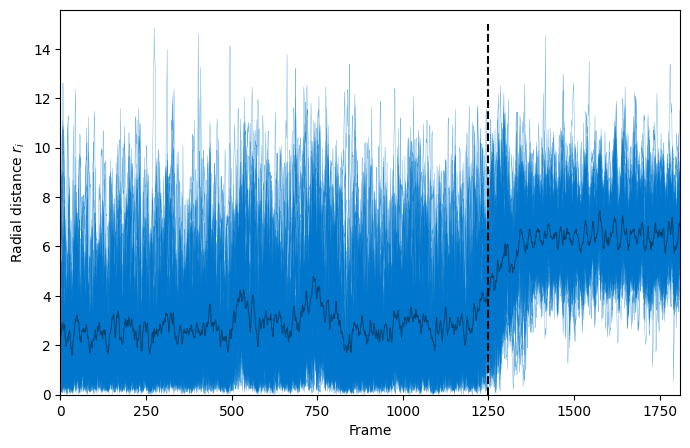

In [30]:
# Radial distance plot
fig = plt.figure(figsize=(8, 5))

avg_r = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    frame_info = vwr_df[vwr_df['FRAME'] == i]
    avg_r[i] = np.mean(frame_info['VELOCITY_MAG'])

for a in pd.unique(vwr_df['TRACK_ID']):
    agent_info = vwr_df[vwr_df['TRACK_ID'] == a]
    plt.plot(agent_info['FRAME'], agent_info['VELOCITY_MAG'], linewidth=0.3, alpha=0.6, color='#0077CC')

plt.plot(pd.unique(vwr_df['FRAME']), avg_r, color='#004474', linewidth=0.7)

plt.xlim(0, 1810)
plt.ylim(bottom=0)
plt.vlines(x=1250, ymin=0, ymax=15, linestyles='--', color='k')
plt.ylabel('Radial distance $r_i$')
plt.xlabel('Frame')
plt.savefig('radius.pdf', format='pdf')
plt.show()

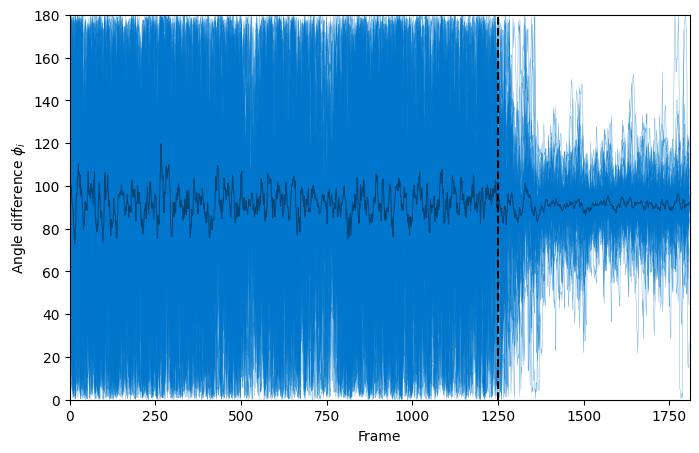

In [33]:
# Plot for angle difference
# Radial distance plot
fig = plt.figure(figsize=(8, 5))

avg_angv = np.zeros(len(pd.unique(vwr_df['FRAME'])))

for i in pd.unique(vwr_df['FRAME']):
    frame_info = vwr_df[vwr_df['FRAME'] == i]
    avg_angv[i] = np.mean(frame_info['ANGLE_DIFF'])

for a in pd.unique(vwr_df['TRACK_ID']):
    agent_info = vwr_df[vwr_df['TRACK_ID'] == a]
    plt.plot(agent_info['FRAME'], agent_info['ANGLE_DIFF'], linewidth=0.3, alpha=0.6, color='#0077CC')

plt.plot(pd.unique(vwr_df['FRAME']), avg_angv, color='#004474', linewidth=0.7)

plt.xlim(0, 1810)
plt.ylim(0, 180)
plt.vlines(x=1250, ymin=0, ymax=180, linestyles='--', color='k')
plt.ylabel('Angle difference $\phi_i$')
plt.xlabel('Frame')
plt.savefig('angle_diff.pdf', format='pdf')
plt.show()

/tmp/ipykernel_1295/2131207885.py:41: RuntimeWarning: invalid value encountered in scalar divide
  vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)


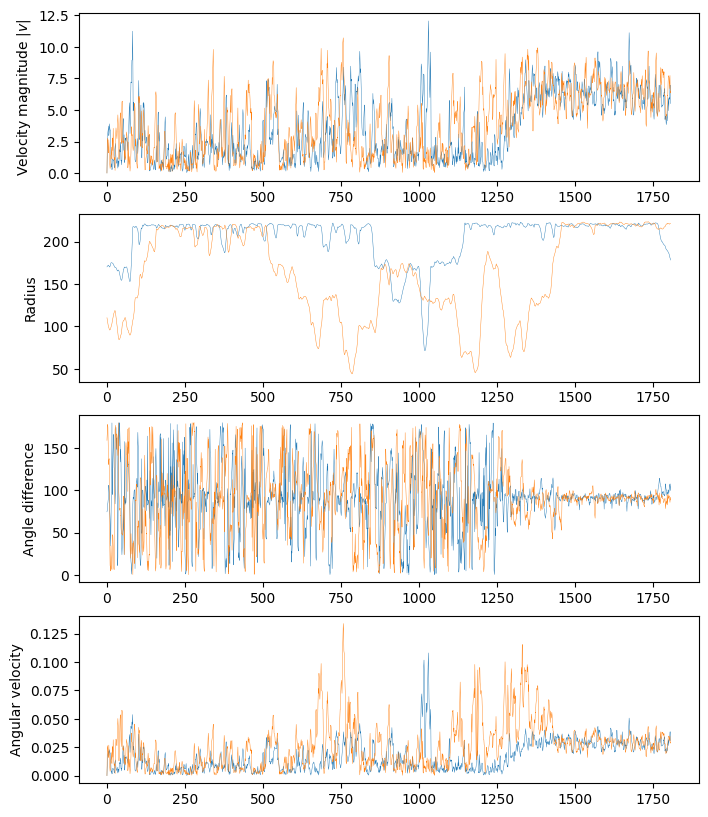

In [6]:
import matplotlib.pyplot as plt

#fig, (ax_v, ax_r, ax_ang, ax_angv) = plt.subplots(4, 1, figsize=(8, 10))
fig, (ax_v, ax_r, ax_ang, ax_angv) = plt.subplots(4, 1, figsize=(8, 10))
 
for a in range(2):
    if not (a == 73):
        # Calculate v, w and r per agent
        agent = experiments[experiments['TRACK_ID'] == a]

        vel_x = np.zeros(len(agent['FRAME']))
        vel_y = np.zeros(len(agent['FRAME']))
        vel_mag = np.zeros(len(agent['FRAME']))

        ang = np.zeros(len(agent['FRAME']))
        ang_vel = np.zeros(len(agent['FRAME']))

        r = np.zeros(len(agent['FRAME']))

        ind_prev = agent[agent['FRAME'] == 0].index
        x_prev = agent.loc[ind_prev, 'POSITION_X'].iloc[0] - 240
        y_prev = agent.loc[ind_prev, 'POSITION_Y'].iloc[0] - 240

        r[0] =  np.sqrt(x_prev**2 + y_prev**2)
        r_prev = r[0]

        # Assume unit time step per frame
        frames = agent.sort_values(by='FRAME')['FRAME'].values
        for i in frames:
            ind = agent[agent['FRAME'] == i].index
            x = agent.loc[ind, 'POSITION_X'].iloc[0] - 240
            y = agent.loc[ind, 'POSITION_Y'].iloc[0] - 240

            vel_x[i] = x - x_prev
            vel_y[i] = y - y_prev
            vel_mag[i] = np.sqrt(vel_x[i]**2 + vel_y[i]**2)

            r[i] =  np.sqrt(x**2 + y**2)
            ang_vel[i] = vel_mag[i]/r[i]

            vec_cos = (x_prev*(vel_x[i]) + y_prev*vel_y[i])/(vel_mag[i]*r_prev)
            angle_rad = np.arccos(vec_cos)
            ang[i] = np.degrees(angle_rad)

            # Update values
            ind_prev = ind
            x_prev = x
            y_prev = y
            r_prev = r[i]

        vwr_df = pd.DataFrame({'TRACK_ID': agent['TRACK_ID'], 'FRAME': frames,
                            'VELOCITY_X': vel_x, 'VELOCITY_Y': vel_y, 'VELOCITY_MAG': vel_mag, 
                            'RADIUS': r, 'ANGULAR_VELOCITY': ang_vel})
        
        ax_v.plot(frames, vel_mag, linewidth=0.3)
        ax_r.plot(frames, r, linewidth=0.3)
        ax_ang.plot(frames, ang, linewidth=0.3)
        ax_angv.plot(frames, ang_vel, linewidth=0.3)

ax_v.set_ylabel('Velocity magnitude $\\vert v \\vert$')
ax_r.set_ylabel('Radius')
ax_ang.set_ylabel('Angle difference')
ax_angv.set_ylabel('Angular velocity')
plt.show()

In [7]:
# Initial and final snapshot
vel_x, vel_y

(array([0.   , 2.274, 2.13 , ..., 6.814, 5.954, 6.038]),
 array([ 0.   , -1.232, -1.779, ...,  3.661,  2.178,  2.408]))

In [8]:
# Make pretty plots

In [9]:
# Find the ranges

In [10]:
# Velocity field